In [1]:
# SETUP : importing

import numpy as np
import math
import pandas as pd

from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style="darkgrid")

from sklearn.datasets import load_boston

from scipy import stats
from statsmodels.stats import diagnostic

import statsmodels.api as sm
import statsmodels.formula.api as smf
import sklearn.linear_model as lm
from sklearn.model_selection import KFold

import sklearn.metrics as mtr
from scipy import stats

import utilcompute as uc
import preprocessing as pre
from pprint import pprint


C:\Users\danis_p50\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
#data = np.column_stack( (load_boston().data, load_boston().target) )
#df = pd.DataFrame(data)
#df.columns = [
#    'CRIM',    # per capita crime rate by town
#    'ZN',      # proportion of residential land zoned for lots over 25,000 sq.ft.
#    'INDUS',   # proportion of non-retail business acres per town
#    'CHAS',    # Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
#    'NOX',     # nitric oxides concentration (parts per 10 million)
#    'RM',      # average number of rooms per dwelling
#    'AGE',     # proportion of owner-occupied units built prior to 1940
#    'DIS',     # weighted distances to five Boston employment centres
#    'RAD',     # index of accessibility to radial highways
#    'TAX',     # full-value property-tax rate per $10,000
#    'PTRATIO', # pupil-teacher ratio by town
#    'B',       # 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
#    'LSTAT',   # % lower status of the population
#    'MEDV'     # median value of owner-occupied homes in $1000's
#]

In [3]:
df = pd.read_excel(io = '../datasets/concrete_compressive_strength.xls')
df.columns = ['cement', 'bfs', 'fly_ash', 'water', 'superplasticizer ', 'c_aggregate', 'f_aggregate', 'age', 'ccs']


In [4]:
# SETUP : printing aggregated info

#print(load_boston().DESCR)
s = uc.summary(df)
print(s)

                     dtype nan_tot nan_prc nan_resp_prc uniques_tot  \
cement             float64       0       0            0         280   
bfs                float64       0       0            0         187   
fly_ash            float64       0       0            0         163   
water              float64       0       0            0         205   
superplasticizer   float64       0       0            0         155   
c_aggregate        float64       0       0            0         284   
f_aggregate        float64       0       0            0         304   
age                  int64       0       0            0          14   
ccs                float64       0       0            0         938   

                  uniques_prc  
cement                  27.18  
bfs                     18.16  
fly_ash                 15.83  
water                    19.9  
superplasticizer        15.05  
c_aggregate             27.57  
f_aggregate             29.51  
age                      1.36  
c

In [5]:
#target = 'MEDV'
target = 'ccs'

if (isinstance(target, list)):
    features = [c for c in df.columns.values.tolist() if (c not in target)]
else:
    features = [c for c in df.columns.values.tolist() if (c != target)]

#print('features : ', features)
#print('target   : ', target)

In [6]:
# SHUFFLING 

seed = 10
np.random.seed(seed)

df = df.reindex(np.random.permutation(df.index))


In [7]:
results = sm.OLS(df[target], df[features]).fit()
print (results.summary())


                            OLS Regression Results                            
Dep. Variable:                    ccs   R-squared:                       0.931
Model:                            OLS   Adj. R-squared:                  0.931
Method:                 Least Squares   F-statistic:                     1732.
Date:                Fri, 05 Jan 2018   Prob (F-statistic):               0.00
Time:                        12:03:37   Log-Likelihood:                -3869.4
No. Observations:                1030   AIC:                             7755.
Df Residuals:                    1022   BIC:                             7794.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
cement                0.1134      0.00

In [8]:
def update_influence_stats(df, features, target, sm_results):
    if (
        df.empty
        or not features
        or not target
        or not sm_results
    ):
        return
    
    df_temp = df.copy(deep = True)
        
    influence = sm_results.get_influence()

    studentized_residuals = influence.resid_studentized_external
    leverage = influence.hat_matrix_diag
    (cooks, p) = influence.cooks_distance
    (dffits, p) = influence.dffits

    df_temp['st_res'] = studentized_residuals
    df_temp['leverage'] = leverage
    df_temp['cooks'] =  cooks
    df_temp['dffits'] = dffits
    
    return df_temp


In [9]:
def compute_influence_cutoffs(df, features, target):    
    if (
        df.empty
        or not features
        or not target
    ):
        return
        
    n = len(df)
    p = len(features)
    
    st_res_threshold = 2
    lev_threshold = 3*(p/n)
    cooks_threshold = 4 / (n - p - 1)
    dffits_threshold = 2 * np.sqrt( (p+1) / (n - p - 1) )   
    
    d = {
        'st_res_threshold' : st_res_threshold,
        'lev_threshold'    : lev_threshold,
        'cooks_threshold'  : cooks_threshold,
        'dffits_threshold' : dffits_threshold        
    }
    
    return d

In [10]:
def plot_influential_point(df):
    if (
        df.empty
        or 'st_res' not in df.columns
        or 'leverage' not in df.columns
        or 'cooks' not in df.columns
        or 'dffits' not in df.columns
    ):
        return
    
    d = compute_influence_cutoffs(df = df, features = features, target = target)
    
    criteria_list = [
        (abs(df['st_res']) > d['st_res_threshold']) & (df['leverage'] > d['lev_threshold']),
        (df['cooks'] > d['cooks_threshold']) ,
        (abs(df['dffits']) > d['dffits_threshold']) 
    ]
    
    fig, axs = plt.subplots(nrows = 1, ncols = len(criteria_list), figsize=(20, 5), sharey = True)    
    current_pal = sns.color_palette()
    
    titles = ['', "cook's distance", 'dffits']
    
    for (criteria_index, criteria) in enumerate(criteria_list) :
        ax = axs[criteria_index]
        
        subset = df[np.logical_not(criteria)]
        x = np.sqrt(subset['st_res'] ** 2)
        ax.scatter(x, subset['leverage'], color = current_pal[0], label = 'non influential')
        
        subset = df[criteria]
        x = np.sqrt(subset['st_res'] ** 2)
        prc = round( (len(subset) / len(df)) * 100, 2)
        ax.scatter(x, subset['leverage'], color = current_pal[2], label = 'influential ({0} %)'.format(prc))
        
        #ax.set_ylim(bottom = -0.005)
        ax.plot((d['st_res_threshold'],d['st_res_threshold']), (0,ax.get_ylim()[1]), 
                color = current_pal[0], linestyle = '--', linewidth = 3)  
        ax.plot((0,ax.get_xlim()[1]), (d['lev_threshold'],d['lev_threshold']), 
                color = current_pal[0], linestyle = '--', linewidth = 3)
        
        ax.legend(loc='best')
        ax.set_xlabel('st_res')
        ax.set_ylabel('leverage')
        ax.set_title(titles[criteria_index])
        
    plt.show()
    

studentized residuals    :         2
leverage                 :    0.0233
cook's distance          :    0.0039
dffits                   :    0.1878


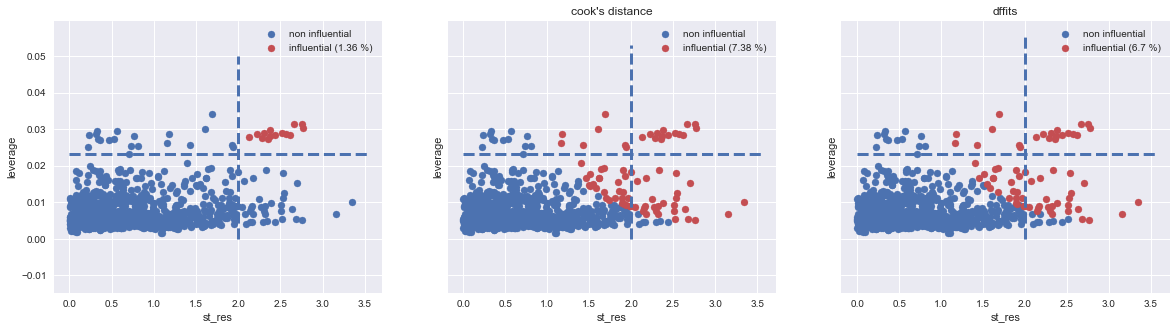

In [11]:
df = update_influence_stats(df = df, features = features, target = target, sm_results = results)

d = compute_influence_cutoffs(df = df, features = features, target = target)
template = "{0:<25}:{1:>10}" 
print(template.format('studentized residuals', d['st_res_threshold']))
print(template.format('leverage', round(d['lev_threshold'], 4)))
print(template.format("cook's distance", round(d['cooks_threshold'], 4)))
print(template.format('dffits', round(d['dffits_threshold'], 4)))

plot_influential_point(df = df)

In [12]:
def compute_kfold_stats(df, features, target, linear_model_name, linear_model_args, note):
    
    if (
        df.empty
        or not features
        or not target
        or not linear_model_name    
    ):
        return
    
    n_splits = 10
    kf = KFold(n_splits = n_splits, shuffle = False, random_state = None)    
    
    columns = [
        'linear_model_name', 'note', 'iteration', 
        'residuals', 'res_normality', 'res_homoscedasticity', 'err_train', 'err_test'] + ['intercept', 'coef'] + features
    results_df = pd.DataFrame(data = None, index = None, columns = columns)


    kf = KFold(n_splits = n_splits, shuffle = False, random_state = None)    
    for k, (train_positions, test_positions) in enumerate(kf.split(X = df[features], y = df[target])) :

        fold_train = df.iloc[train_positions]   
        fold_test = df.iloc[test_positions]  

        linear_model_class_ = getattr(lm, linear_model_name)
        if (linear_model_args):
            model = linear_model_class_(**linear_model_args)
        else:
            model = linear_model_class_()
        
        model.fit(fold_train[features], fold_train[target])

        y_pred_train = model.predict(fold_train[features])
        y_pred_test = model.predict(fold_test[features])
        
        residuals_test = (fold_test[target] - y_pred_test)
        
        res_normality = round(stats.shapiro(residuals_test)[0],4)
        res_homoscedasticity = diagnostic.het_breuschpagan(resid = residuals_test, exog_het = fold_test[features])[3]
        
        r2_train = mtr.r2_score(y_true = fold_train[target], y_pred = y_pred_train)
        r2_test = mtr.r2_score(y_true = fold_test[target], y_pred = y_pred_test)
        
        values_dict = {
            'linear_model_name'    : linear_model_name,
            'note'                 : note,
            'iteration'            : k + 1,  
            
            'residuals'            : residuals_test,
            'res_normality'        : res_normality,
            'res_homoscedasticity' : res_homoscedasticity,
            
            'err_train'            : 1 - r2_train,
            'err_test'             : 1 - r2_test,
            
            'intercept'            : model.intercept_, 
            'coef'                 : model.coef_
        }

        for f in range(len(features)):
            values_dict[features[f]] = model.coef_[f]
        
        results_index = k
        results_df.loc[results_index] = values_dict     

    #results_df = results_df.astype(dtype = 'float')
        
    return results_df


In [13]:
influential_criteria = ( 
    (abs(df['st_res']) > d['st_res_threshold']) & (df['leverage'] > d['lev_threshold']) 
    & (df['cooks'] > d['cooks_threshold'])
)

index_list = df[influential_criteria].index.values.tolist()

df_temp = df.copy(deep = True)
results = compute_kfold_stats(
        df = df_temp, 
        features = features, 
        target = target, 
        linear_model_name = 'LinearRegression', 
        linear_model_args = None,
        note = 0
    )
for (index_pos, index) in enumerate(index_list):  
    #print('number of features removed : {0}'.format(len(df) - len(df_temp)))
    results_temp = compute_kfold_stats(
        df = df_temp, 
        features = features, 
        target = target, 
        linear_model_name = 'LinearRegression', 
        linear_model_args = None,
        note = index_pos + 1
    )
    results = results.append(results_temp).reset_index(drop = True)
    index = index_list[index_pos]
    #print('i: {0} | index : {1}'.format(index_pos, index))
    df_temp.drop(labels = index, axis = 0, inplace = True)

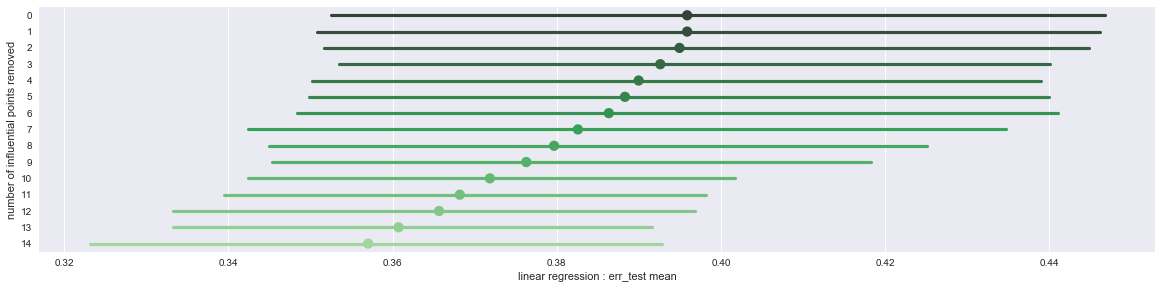

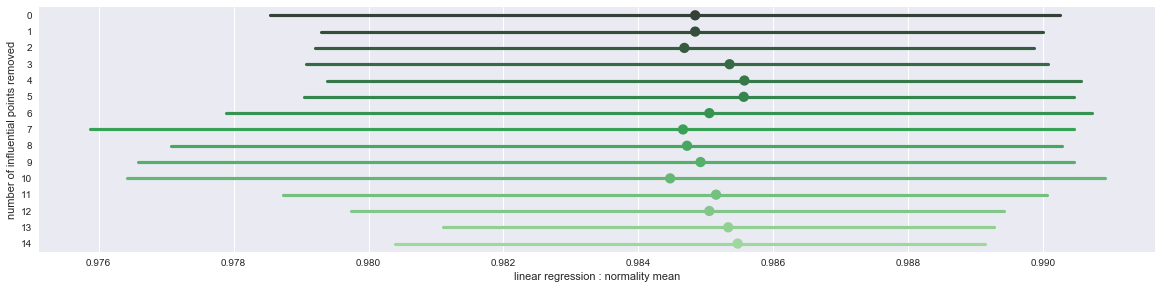

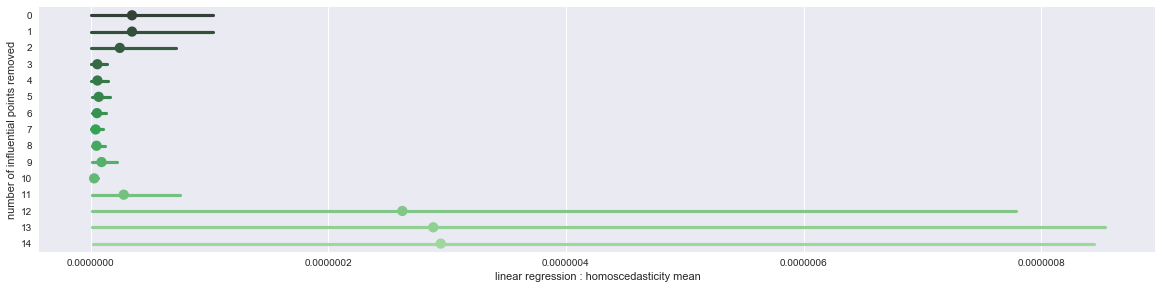

In [14]:
discriminant_values = results['note'].unique()

fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize=(20, 0.3*len(discriminant_values)))
pal = sns.color_palette("Greens_d", len(discriminant_values))

ax = axs    
#sns.barplot(x = 'err_test', y = 'note', data = results, order = discriminant_values, ci = None, ax = ax, palette = pal) 
sns.pointplot(x = 'err_test', y = 'note', data = results, estimator = np.mean, orient = 'h', ax = ax, palette = pal)
ax.set_xlabel('linear regression : err_test mean')
ax.set_ylabel('number of influential points removed')

plt.show()


fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize=(20, 0.3*len(discriminant_values)))
pal = sns.color_palette("Greens_d", len(discriminant_values))

ax = axs 
sns.pointplot(x = 'res_normality', y = 'note', data = results, estimator = np.mean, orient = 'h', ax = ax, palette = pal)
ax.set_xlabel('linear regression : normality mean')
ax.set_ylabel('number of influential points removed')

plt.show()



fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize=(20, 0.3*len(discriminant_values)))
pal = sns.color_palette("Greens_d", len(discriminant_values))

ax = axs 
sns.pointplot(x = 'res_homoscedasticity', y = 'note', data = results, estimator = np.mean, orient = 'h', ax = ax, palette = pal)
ax.set_xlabel('linear regression : homoscedasticity mean')
ax.set_ylabel('number of influential points removed')

plt.show()
